<a href="https://colab.research.google.com/github/DhrubaAdhikary/ERA_V2/blob/master/S7/ERA1_S7_step3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

## Loading Models

In [2]:
!pip install torchsummary
!git clone https://github.com/DhrubaAdhikary/ERA_V2.git -q --quiet
!mv ERA_V2/S7/*.py .
!rm -rf ERA_V2

## Step 3
### Target
1. Include StepLR rate schedule
2. Optimize the learning rate and drop out value


In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations


In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [5]:
train = datasets.MNIST('./data', train=True, download = True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 125145495.12it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39509358.72it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44979359.62it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5302123.23it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Dataloader Arguments & Test/Train Dataloaders

In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Availalbe?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle=True,batch_size=128,num_workers=4,pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Availalbe? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Model

In [7]:
from model import *
Net = Model_3

## Model Params

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,152
              ReLU-4           [-1, 16, 24, 24]               0
       BatchNorm2d-5           [-1, 16, 24, 24]              32
           Dropout-6           [-1, 16, 24, 24]               0
            Conv2d-7            [-1, 8, 24, 24]             128
         MaxPool2d-8            [-1, 8, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           1,152
             ReLU-10           [-1, 16, 10, 10]               0
      BatchNorm2d-11           [-1, 16, 10, 10]              32
          Dropout-12           [-1, 16, 10, 10]               0
           Conv2d-13              [-1, 8, 8, 8]           1,152
             ReLU-14              

## Training and Testing

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.06900697946548462 Batch_id=468 Accuracy=92.44: 100%|██████████| 469/469 [00:28<00:00, 16.68it/s]



Test set: Average loss: 0.0512, Accuracy: 9849/10000 (98.49%)

EPOCH: 1


Loss=0.033361345529556274 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:20<00:00, 22.84it/s]



Test set: Average loss: 0.0351, Accuracy: 9886/10000 (98.86%)

EPOCH: 2


Loss=0.13216592371463776 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:21<00:00, 21.68it/s]



Test set: Average loss: 0.0340, Accuracy: 9886/10000 (98.86%)

EPOCH: 3


Loss=0.07010658830404282 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:21<00:00, 21.48it/s]



Test set: Average loss: 0.0295, Accuracy: 9909/10000 (99.09%)

EPOCH: 4


Loss=0.039672356098890305 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:22<00:00, 20.91it/s]



Test set: Average loss: 0.0282, Accuracy: 9912/10000 (99.12%)

EPOCH: 5


Loss=0.04235228896141052 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:21<00:00, 21.81it/s]



Test set: Average loss: 0.0245, Accuracy: 9926/10000 (99.26%)

EPOCH: 6


Loss=0.024998739361763 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:20<00:00, 22.38it/s]



Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)

EPOCH: 7


Loss=0.007736611645668745 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:21<00:00, 21.84it/s]



Test set: Average loss: 0.0204, Accuracy: 9935/10000 (99.35%)

EPOCH: 8


Loss=0.045235950499773026 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:20<00:00, 22.86it/s]



Test set: Average loss: 0.0200, Accuracy: 9936/10000 (99.36%)

EPOCH: 9


Loss=0.0677364394068718 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:21<00:00, 21.75it/s]



Test set: Average loss: 0.0201, Accuracy: 9930/10000 (99.30%)

EPOCH: 10


Loss=0.012439541518688202 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:21<00:00, 21.79it/s]



Test set: Average loss: 0.0199, Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.028284413740038872 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:21<00:00, 21.95it/s]



Test set: Average loss: 0.0193, Accuracy: 9938/10000 (99.38%)

EPOCH: 12


Loss=0.021705543622374535 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:20<00:00, 22.73it/s]



Test set: Average loss: 0.0192, Accuracy: 9943/10000 (99.43%)

EPOCH: 13


Loss=0.017612675204873085 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:20<00:00, 22.86it/s]



Test set: Average loss: 0.0188, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.007887125946581364 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]



Test set: Average loss: 0.0190, Accuracy: 9937/10000 (99.37%)



Text(0.5, 1.0, 'Test Accuracy')

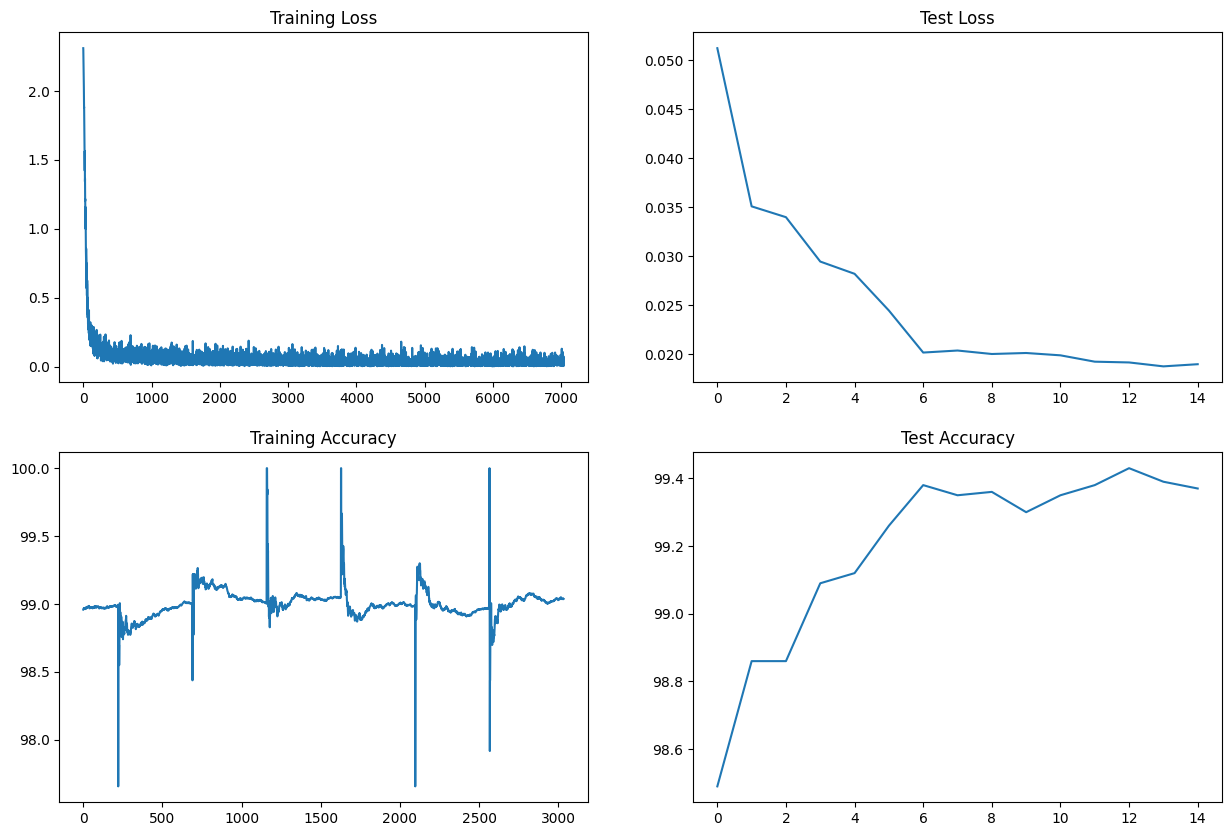

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")